# Detección de tweets meteorológicos con Bag of Words

In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

#### Cargo la base de datos clasificada y genero las variables de importancia

In [2]:
TW = pd.read_csv('base_corr.csv')

In [5]:
TW.keys()[-3:]

Index(['Tag', 'Num', 'Nombre'], dtype='object')

In [6]:
MSJ = TW['Twit']
TAG = TW['Tag']
NUM = TW['Num']

### Defino una variable cantidad que tiene la cantidad de tw de cada tipo

In [7]:
cant = [len (np.array(TAG) [np.where(TAG == 0)]) , len (np.array(TAG) [np.where(TAG == 1)])]

In [8]:
len(MSJ)

773

#### Elimino las cosas innecesarias de msj

In [9]:
def normalizacion(mensaje):
    
    mensaje = list(mensaje)
    lenght = len(mensaje)
    
    lista_ascii = [['\\xe1', '\\xe9', '\\xed', '\\xf3', '\\xfa', '\\xf1', '\\xd1', '\\xc1','\\xc9', '\\xcd', '\\xd3', 
                 '\\xda', '\\xa1', '\\xbf', '\\xdc', '\\xfc', '\\xb4', '\\xba', '\\xaa', '\\xb7','\\xc7','\\xe7',
                 '\\xa8', '\\xb0C', '\\n', '\\xb0c', '\\xbb', 'xb0', '\\ufe0f'],['a', 'e', 'i', 'o', 'u', 'ñ', 'Ñ', 'A', 'E', 'I', 'O', 'U', '', '', 'Ü', 'ü', '', 
                           ' ', '', '','Ç','ç','', ' ', ' ', ' ', ' ', ' ', ' ']]
    lista_simb = ['!','\'', '\"', "|", '$', "%", "&", "(", ")", "=", "?", "+",'/', ";", "_", "-", "1","2","3","4","5","6","7","8","9","0", '*',',', '.', ':', '#']
    
    ign_palabras = ['mbar','cdu','s','la','lo','st','que','este', 'me','t','p','el','weathercloud','en','h','temp','hpa','km','mm',"su","vos",'que',"re","xq","le","te","tu","soy","sos","mi","da","o","x","les","me","d","q", "como", "lo", "los", "mi", "son", "a", "el", 
                    "un","la", "una","en","por","para", 'las',"ante", "al", 'me',"rt", "del", "y", "se", "de", "que", "sus", "ha", "es", "con", "esta"]
    
    for i in range(lenght):
        
        ## Convierto mayúsculas en minúsculas
        mensaje[i] = mensaje[i].lower()
        
        ## Saco las menciones y otras cosas
        txt = mensaje[i].split()
        
        for j in range(len(txt)):
            if ('@' in txt[j]) and ('RELAMPAGO2018' not in txt[j]) and ('RELAMPAGO_edu' not in txt[j]) or ('jaj' in txt[j]) or ('https' in txt[j]): txt[j]=''
        
        mensaje[i] = " ".join(txt)
        
        ## Reemplazo símbolos
        for h in range(len(lista_simb)):
            mensaje[i] = mensaje[i].replace(lista_simb[h], ' ')
            
        ## Convierto el msj a ASCII, reemplazo los errores de decodificación y agrego un espacio antes de cada decodificación
        mensaje[i] = mensaje[i].encode('unicode-escape').decode('ASCII')+" "     
        
        for j in range(len(lista_ascii[0])):
            mensaje[i] = mensaje[i].replace(lista_ascii[0][j], lista_ascii[1][j])
        
        mensaje[i] = mensaje[i].replace('\\', ' \\')
        
        for j in range(len(ign_palabras)):
            mensaje[i] = mensaje[i].replace(" "+ign_palabras[j]+" ", ' ')
        
    return(mensaje)

In [10]:
msj = normalizacion(MSJ)

In [32]:
len(msj)

773

#### División en datasets de  _train_ y _test_

In [11]:
size = 0.8

## Toma los tweets, los asocia con su tag y luego los divide en cada una de las palabras que los componen
## zip() itera tuplas
train = [(i.split(),j) for i,j in zip(list(msj)[1:int(len(msj)*0.8)],list(TAG)[1:int(len(msj)*0.8)])]

test = [(i.split(),j) for i,j in zip(list(msj)[int(len(msj)*0.8)+1:len(msj)],list(TAG)[int(len(msj)*0.8)+1:len(msj)])]

## No entiendo bien que es esto
label_to_ix = { 1: 0, 0: 1 }



#### Generación del diccionario con el dataset completo

In [12]:
word_to_ix = {}

## Cada palabra que encuentra la guarda en un diccionario
for sent, _ in train+test:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

VOCAB_SIZE = len(word_to_ix)
NUM_LABELS = 2

#### Bag of Words

In [13]:
class BoWClassifier(nn.Module): # inheriting from nn.Module!
    
    def __init__(self, num_labels, vocab_size):
        
        super(BoWClassifier, self).__init__()

        self.linear = nn.Linear(vocab_size, num_labels)
        
        
    def forward(self, bow_vec):
        # Pass the input through the linear layer,
        # then pass that through log_softmax.
        # Many non-linearities and other functions are in torch.nn.functional
        return F.log_softmax(self.linear(bow_vec), dim=1)
    
    def make_bow_vector(sentence, word_to_ix):
        vec = torch.zeros(len(word_to_ix))
        for word in sentence:
            vec[word_to_ix[word]] += 1
        return vec.view(1, -1)

    def make_target(label, label_to_ix):
        
        return torch.LongTensor([label_to_ix[label]])
    
model = BoWClassifier(NUM_LABELS, VOCAB_SIZE)

Ejemplo de BoWClassifier

In [14]:
## Tomo un tweet
sample = train[0]
print (sample)

## Genera el BowVector, es del largo del diccionario y tiene unos en las posiciones donde las palabras del tweet coinciden con el diccionario
bow_vector = BoWClassifier.make_bow_vector(sample[0], word_to_ix)
print(bow_vector)

## Aplico el modelo y obtengo la probabilidad de que el tweet sea meteorológico o no meteorológico
log_probs = model(bow_vector)
print (log_probs.exp())

(['quiero', 'ir', 'centro', 'mañana', 'pero', 'seguro', 'llueve'], 0)
tensor([[1., 1., 1.,  ..., 0., 0., 0.]])
tensor([[0.4909, 0.5091]], grad_fn=<ExpBackward>)


#### Miremos la frecuencia de ocurrencia de palabras en el diccionario

In [15]:
vec = torch.zeros(len(word_to_ix))
for i, label in test+train:
    bow_vector = BoWClassifier.make_bow_vector(i, word_to_ix)
    vec = vec.add(bow_vector)

vec=vec[0].tolist()

In [31]:
## Genero un dataframe que me pemite ordenar de mayor a menor respecto de la columna Frecuencia
tot = pd.DataFrame()
tot['Diccionario'] = list(word_to_ix.keys())
tot['Frecuencia'] = vec
tot['Num'] = word_to_ix.values()
tot = tot.sort_values(by=['Frecuencia'], ascending=False)
tot

,Diccionario,Frecuencia,Num
24,lluvia,424.0,24
29,no,158.0,29
6,llueve,133.0,6
79,tormenta,101.0,79
7,si,60.0,7
42,que,55.0,42
203,\U0001f60d,53.0,203
25,viento,48.0,25
4,pero,46.0,4
231,dormir,45.0,231


#### Probamos la red sin entrenar

In [33]:
# Run on test data before we train, just to see a before-and-after
for instance, label in test:
    bow_vec = BoWClassifier.make_bow_vector(instance, word_to_ix)
    log_probs = model(bow_vec)
    print (log_probs.exp(), label)
print (next(model.parameters())[:,word_to_ix["lluvia"]])

tensor([[9.9988e-01, 1.1814e-04]], grad_fn=<ExpBackward>) 1
tensor([[0.0162, 0.9838]], grad_fn=<ExpBackward>) 1
tensor([[0.9975, 0.0025]], grad_fn=<ExpBackward>) 1
tensor([[1.9199e-06, 1.0000e+00]], grad_fn=<ExpBackward>) 0
tensor([[0.9871, 0.0129]], grad_fn=<ExpBackward>) 1
tensor([[4.1915e-04, 9.9958e-01]], grad_fn=<ExpBackward>) 1
tensor([[9.7792e-05, 9.9990e-01]], grad_fn=<ExpBackward>) 0
tensor([[1.5951e-06, 1.0000e+00]], grad_fn=<ExpBackward>) 1
tensor([[0.0479, 0.9521]], grad_fn=<ExpBackward>) 1
tensor([[0.0125, 0.9875]], grad_fn=<ExpBackward>) 1
tensor([[0.0342, 0.9658]], grad_fn=<ExpBackward>) 1
tensor([[4.1250e-04, 9.9959e-01]], grad_fn=<ExpBackward>) 1
tensor([[5.3431e-06, 9.9999e-01]], grad_fn=<ExpBackward>) 0
tensor([[0.1390, 0.8610]], grad_fn=<ExpBackward>) 1
tensor([[2.5799e-04, 9.9974e-01]], grad_fn=<ExpBackward>) 1
tensor([[0.0285, 0.9715]], grad_fn=<ExpBackward>) 0
tensor([[5.6087e-04, 9.9944e-01]], grad_fn=<ExpBackward>) 1
tensor([[1.5080e-04, 9.9985e-01]], grad_fn=<

### Entrenamiento

Epoch: 0
Epoch: 50
Epoch: 100
Epoch: 150
Epoch: 200
Epoch: 250
Epoch: 300
Epoch: 350
Epoch: 400
Epoch: 450
Epoch: 500
Epoch: 550
Epoch: 600
Epoch: 650


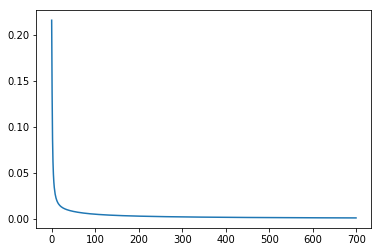

In [18]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Usually you want to pass over the training data several times.
# 100 is much bigger than on a real data set, but real datasets have more than
# two instances.  Usually, somewhere between 5 and 30 epochs is reasonable.

error = []

for epoch in range(700):
    if epoch % 50 == 0: print('Epoch: %i' %epoch)
    for instance, label in train:
        # Step 1. Remember that Pytorch accumulates gradients.  We need to clear them out
        # before each instance
        model.zero_grad()
    
        # Step 2. Make our BOW vector and also we must wrap the target in a Variable
        # as an integer.  For example, if the target is SPANISH, then we wrap the integer
        # 0.  The loss function then knows that the 0th element of the log probabilities is
        # the log probability corresponding to SPANISH
        bow_vec = BoWClassifier.make_bow_vector(instance, word_to_ix)
        target = BoWClassifier.make_target(label, label_to_ix)
    
        # Step 3. Run our forward pass.
        log_probs = model(bow_vec)
    
        # Step 4. Compute the loss, gradients, and update the parameters by calling
        # optimizer.step()
        loss = loss_function(log_probs, target)
        
        loss.backward()
        optimizer.step()
    error.append(loss)
  
plt.figure()
plt.plot(error)
plt.show()

## Usamos los twits de test para verificar

In [36]:
c = [0,0,0,0]
for instance, label in test:
    bow_vec = autograd.Variable(BoWClassifier.make_bow_vector(instance, word_to_ix))
    log_probs = model(bow_vec)
    log_probs_exp = log_probs.exp()
    if bool (log_probs_exp[0][0]>0.5):
        
        if label == 1: 
            c[0]+=1
           # print ('\033[1;93m' , log_probs_exp , label)
        else: 
            c[2]+=1
           # print ('\033[1;31m' , log_probs_exp , label)

    elif bool (log_probs_exp[0][1]>0.5):
        
        if label == 0:
            c[1]+=1
           # print ('\033[1;32m' , log_probs_exp , label)
            
        else:
            c[3]+=1
           # print ('\033[1;66m' , log_probs_exp , label)


print('\033[0m Aciertos a tweets meteorológicos:', round((c[0]/sum(c))*100, 3),
      '% \n Aciertos a tweets no meteorologicos:', round((c[1]/sum(c))*100, 3),
      '% \n Sorpresas: ', round((c[3]/sum(c))*100, 3),
      '% \n Falsos positivos: ', round((c[2]/sum(c))*100, 3), '%') 
print(c)
#print ('\033[0m', next(model.parameters())[:,word_to_ix["lluvia"]]) # Index corresponding to Spanish goes up, English goes down!



 Aciertos a tweets meteorológicos: 19.481 % 
 Aciertos a tweets no meteorologicos: 38.312 % 
 Sorpresas:  38.961 % 
 Falsos positivos:  3.247 %
[30, 59, 5, 60]


## Graficos de verificación

Text(0.5, 1.0, 'Comparativa')

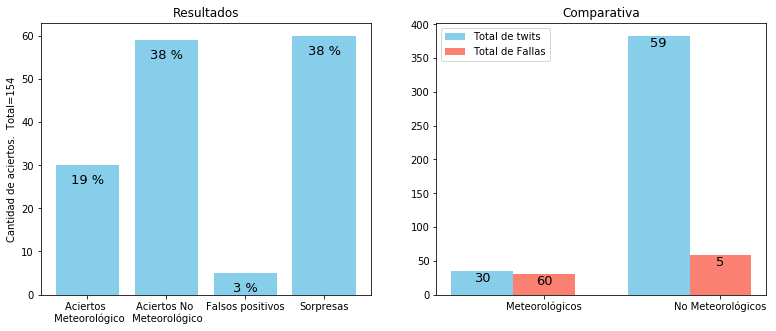

In [38]:
fig = plt.figure(figsize=(13,5))



opacity = 0.4
bar_width = 0.35


"""GRAFICO DE VERIFICACIÓN"""

ax = plt.subplot(1,2,1)

bar = plt.bar(range(4),c,
              tick_label=['Aciertos \n Meteorológico','Aciertos No \n Meteorológico',
                          'Falsos positivos','Sorpresas'], color = 'skyblue')
plt.title('Resultados')
plt.ylabel('Cantidad de aciertos.  Total='+str(sum(c)))
for rect, porcentaje in zip(bar,c):
    height = rect.get_height()- 5
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % round((porcentaje/sum(c))*100, 3) + ' %'
             ,fontsize = 13, color = 'black',ha='center', va='bottom')

  
"""GRÁFICO DE COMPARACIÓN PARA CADA TAG"""
    
ax2 = plt.subplot(1,2,2)

bar1 = plt.bar(np.arange(2), [c[0]+c[2],cant[1]+c[3]], bar_width, 
               tick_label = ['Meteorológicos', 'No Meteorológicos'],
               color = 'skyblue', label = 'Total de twits'
              )

for rect, porcentaje in zip(bar1,c[:2]):
    height = rect.get_height()-20
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % porcentaje
             ,fontsize = 13, color = 'black',ha='center', va='bottom')


bar2 = plt.bar(np.arange(2) +bar_width, [c[0],c[1]], bar_width,
              tick_label = ['Meteorológicos', 'No Meteorológicos'],
               color = 'salmon' , label= 'Total de Fallas'
              )
for rect, porcentaje in zip(bar2,[c[3],c[2]]):
    height = rect.get_height()-20
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % porcentaje
             ,fontsize = 13, color = 'black',ha='center', va='bottom')

plt.legend()
plt.title('Comparativa')

154